#Keras and Tensorflow

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import math

In [92]:
df = pd.read_csv('AAPL.csv')

In [93]:
df.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [94]:
# Keep Date column as index for meaningful plots
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Focus on close prices
data = df[['close']]

In [95]:
data.shape

(1258, 1)

In [96]:
data

,close
date,
2015-05-27 00:00:00+00:00,132.045
2015-05-28 00:00:00+00:00,131.780
2015-05-29 00:00:00+00:00,130.280
2015-06-01 00:00:00+00:00,130.535
2015-06-02 00:00:00+00:00,129.960
...,...
2020-05-18 00:00:00+00:00,314.960
2020-05-19 00:00:00+00:00,313.140
2020-05-20 00:00:00+00:00,319.230


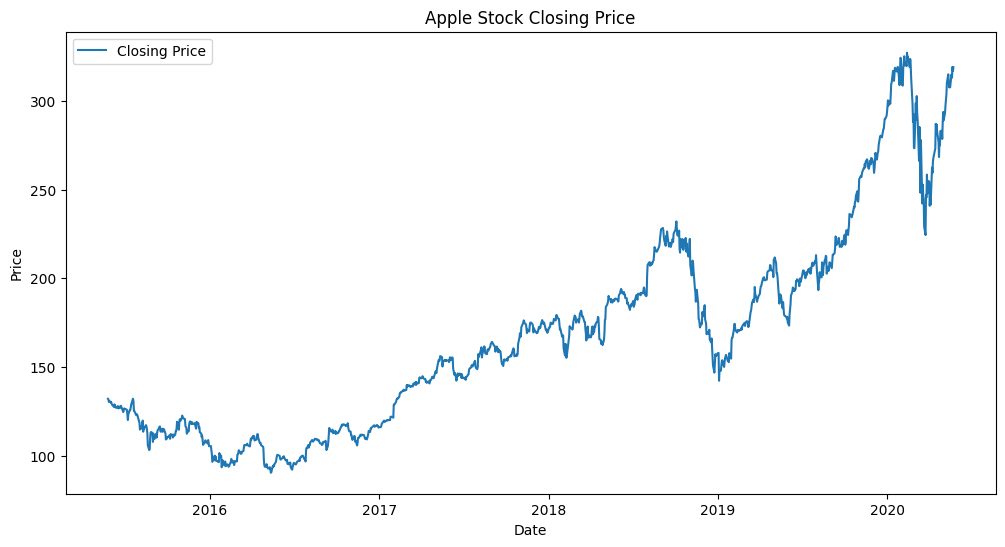

In [97]:
plt.figure(figsize=(12,6))
plt.plot(data, label="Closing Price")
plt.title("Apple Stock Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

###LSTM are sensitive to the state of scale of the data, so we apply MinMax scaler

In [98]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

## Splitting dataset into into training and testing data

In [99]:
training_size = int(len(scaled_data)*0.65)
train_data = scaled_data[:training_size]
test_data = scaled_data[training_size:]

In [100]:
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), 0])
        y.append(dataset[i+time_step, 0])
    return np.array(X), np.array(y)

In [101]:
# reshape into X=t,t+1,t+2,t+3 and t+4
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [102]:
# Reshape into [samples, time steps, features] which is required for LSTM
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [103]:
print("Training set:", x_train.shape, y_train.shape)
print("Testing set:", x_test.shape, y_test.shape)

Training set: (716, 100, 1) (716,)
Testing set: (340, 100, 1) (340,)


In [104]:
# Create the Stacked LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss="mean_squared_error", optimizer="adam")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [105]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [106]:
#Train model with early stopping
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=64,
    verbose=1,
    callbacks=[early_stop]
)


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0275 - val_loss: 0.0558
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0010 - val_loss: 0.0044
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7.7718e-04 - val_loss: 0.0057
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 7.4751e-04 - val_loss: 0.0039
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7.2663e-04 - val_loss: 0.0042
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 7.1043e-04 - val_loss: 0.0045
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 7.2697e-04 - val_loss: 0.0038
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.5723e-04 - val_loss: 0.0046
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7.3587e-04 - val_loss: 0.0043
Epoch 12/100
12/12 ━━━━━

In [107]:
# Let's do the prediction and check performance metrics
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [108]:
# Transform back to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_true = scaler.inverse_transform(y_train.reshape(-1,1))
y_test_true = scaler.inverse_transform(y_test.reshape(-1,1))

In [109]:
#Calculate RSME performance metrics
rmse_train = math.sqrt(mean_squared_error(y_train_true, train_predict))
rmse_test = math.sqrt(mean_squared_error(y_test_true, test_predict))
mae = mean_absolute_error(y_test_true, test_predict)
r2 = r2_score(y_test_true, test_predict)

In [110]:
print(f"Train RMSE: {rmse_train:.2f}")
print(f"Test RMSE: {rmse_test:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R² Score: {r2:.2f}")

Train RMSE: 4.01
Test RMSE: 8.45
Test MAE: 6.03
Test R² Score: 0.97


#Plotting

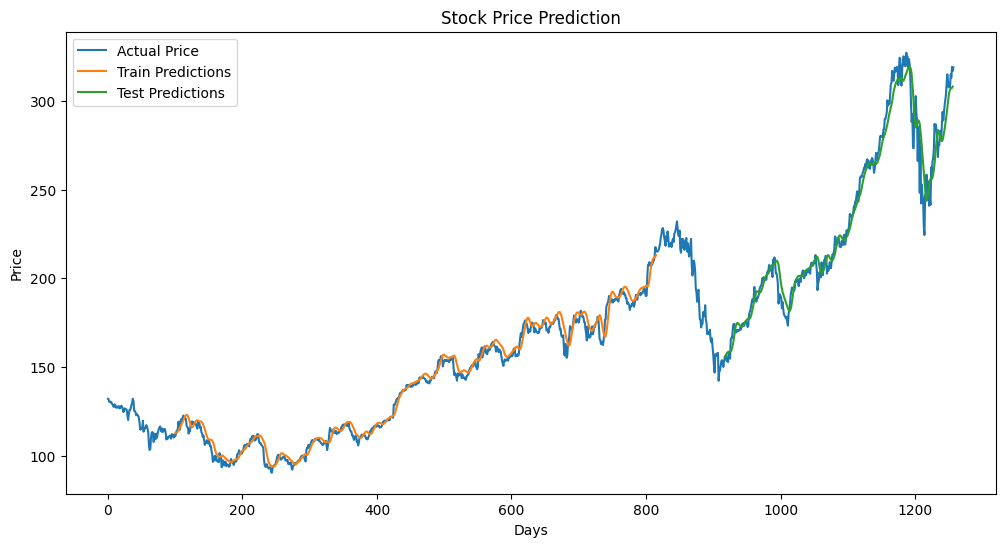

In [111]:
look_back = time_step

train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[look_back:len(train_predict)+look_back, :] = train_predict

test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(train_predict)+(look_back*2)+1:len(scaled_data)-1, :] = test_predict

plt.figure(figsize=(12,6))
plt.plot(scaler.inverse_transform(scaled_data), label="Actual Price")
plt.plot(train_plot, label="Train Predictions")
plt.plot(test_plot, label="Test Predictions")
plt.title("Stock Price Prediction")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()

#Forecasting next 30 days

In [114]:
future_predictions = []
temp_input = list(test_data[-time_step:].flatten()) # Flatten the initial numpy array

for i in range(30):
    x_input = np.array(temp_input[-time_step:]).reshape(1, time_step, 1)
    yhat = model.predict(x_input, verbose=0)
    temp_input.append(yhat[0][0])  # Append the scalar prediction
    future_predictions.append(yhat[0][0])

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))

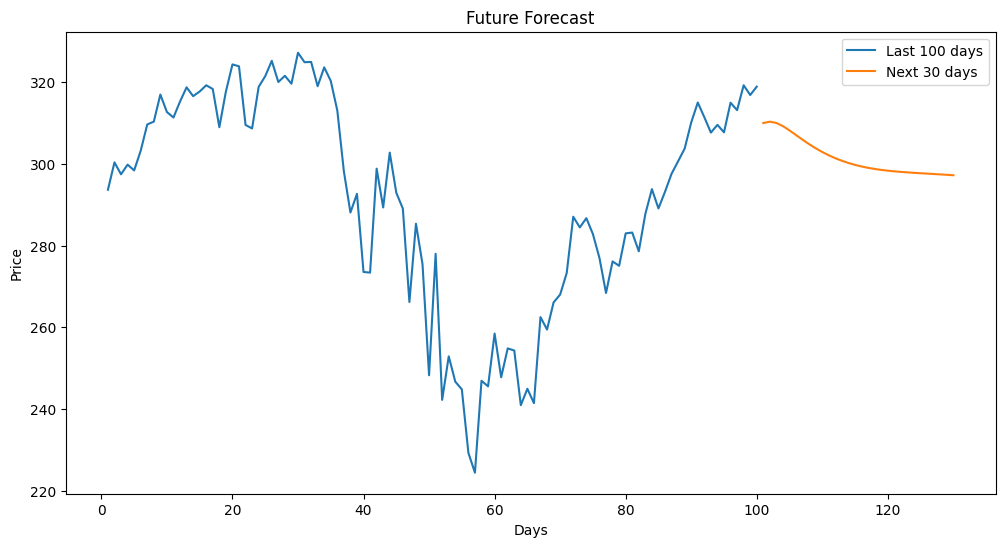

In [115]:
# Plot last 100 days + future predictions
plt.figure(figsize=(12,6))
last_days = scaler.inverse_transform(test_data[-100:])
plt.plot(np.arange(1,101), last_days, label="Last 100 days")
plt.plot(np.arange(101,131), future_predictions, label="Next 30 days")
plt.title("Future Forecast")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()